In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score

Tensorflow version: 2.8.1


In [2]:
print('Available devices:', tf.config.list_physical_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1*1024)]
    )

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-11 10:24:48.331212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 10:24:48.377422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 10:24:48.377648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
DIRECTORY = 'dataset'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 8
COLOR_MODE='rgb'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE    
    , color_mode=COLOR_MODE
    , validation_split=0.1
    , subset="training"
    , seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , color_mode=COLOR_MODE
    , validation_split=0.1
    , subset="validation"
    , seed=123
)

Found 5481 files belonging to 8 classes.
Using 4933 files for training.


2022-11-11 10:24:55.690023: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 10:24:55.690409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 10:24:55.690664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 10:24:55.690814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Found 5481 files belonging to 8 classes.
Using 548 files for validation.


In [4]:
qtyLabels = [0]*8
Images = {}
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        label = int(label)
        qtyLabels[label] += 1  
        if ( label in Images ):
            if  ( len(Images[label]) < 20 ):
                Images[label].append(image)
        else:
            Images[label] = []
            Images[label].append(image)
class_names = train_dataset.class_names
print(' '.join( ['{:<12}'.format(el) for el in class_names] ))
print(' '.join( ['{:<12}'.format(el) for el in qtyLabels] ))

anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
793          191          389          518          1237         446          656          703         


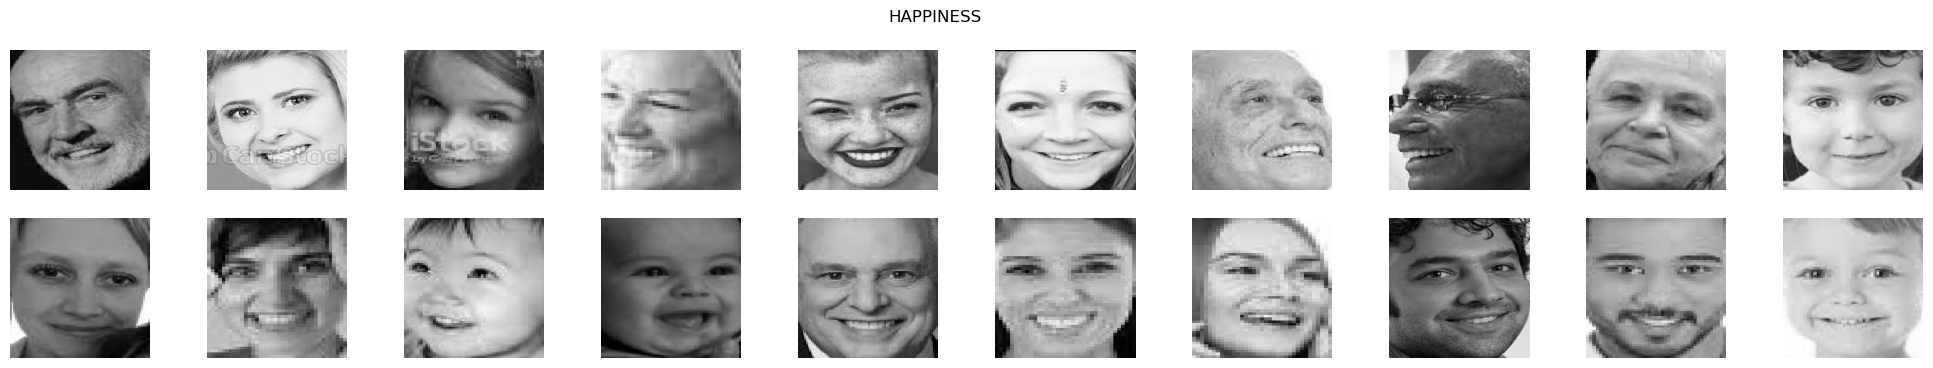

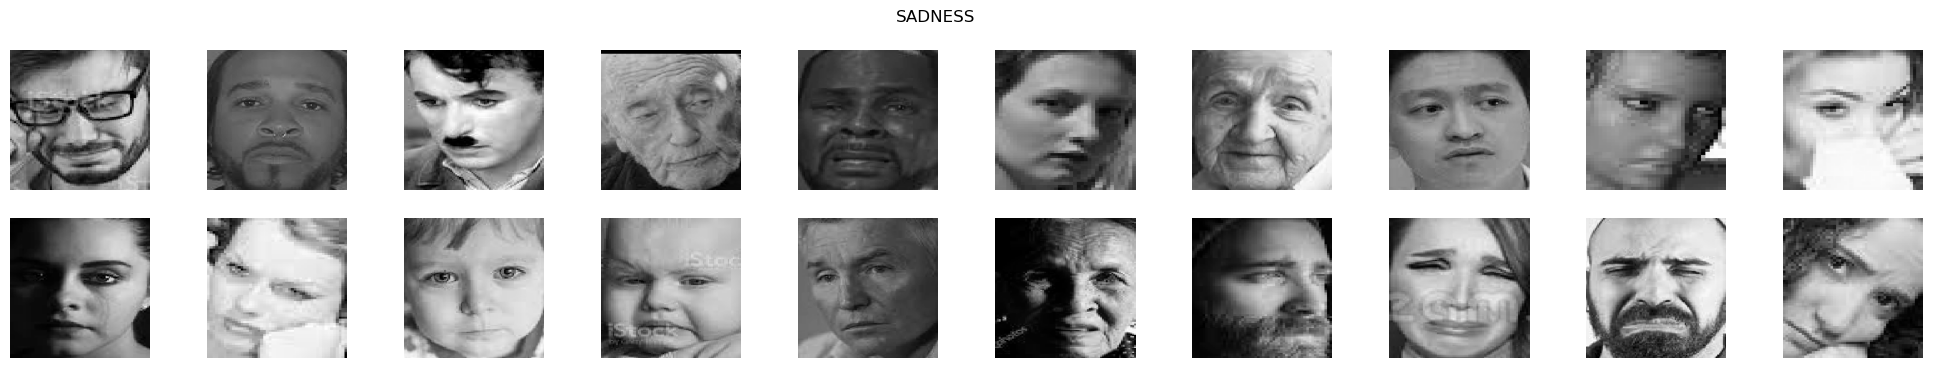

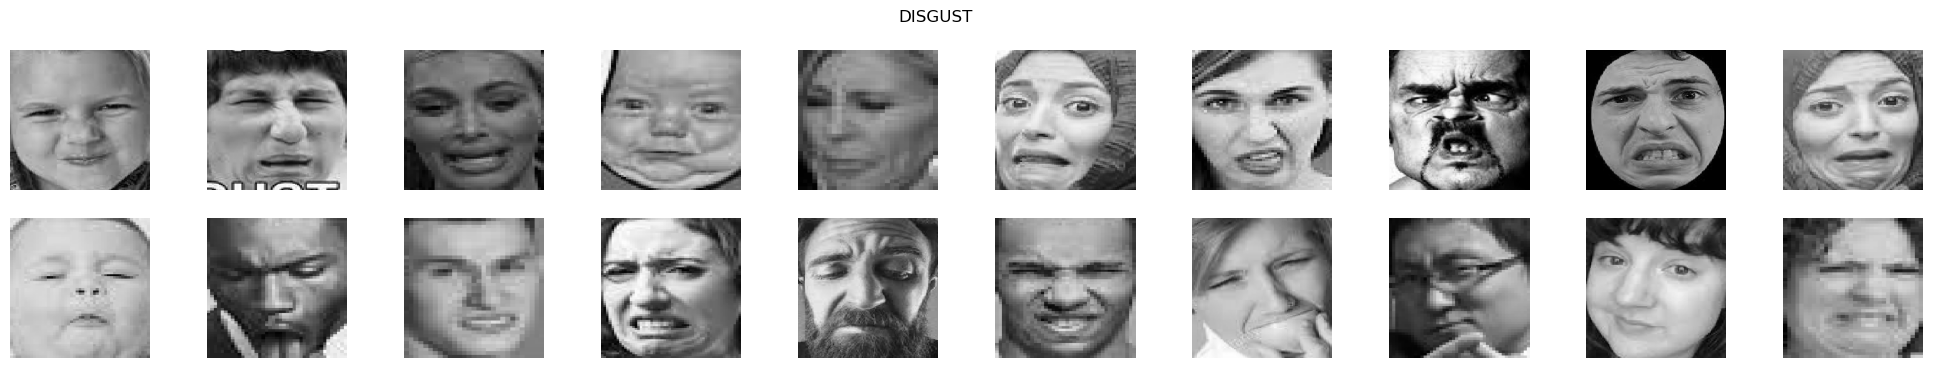

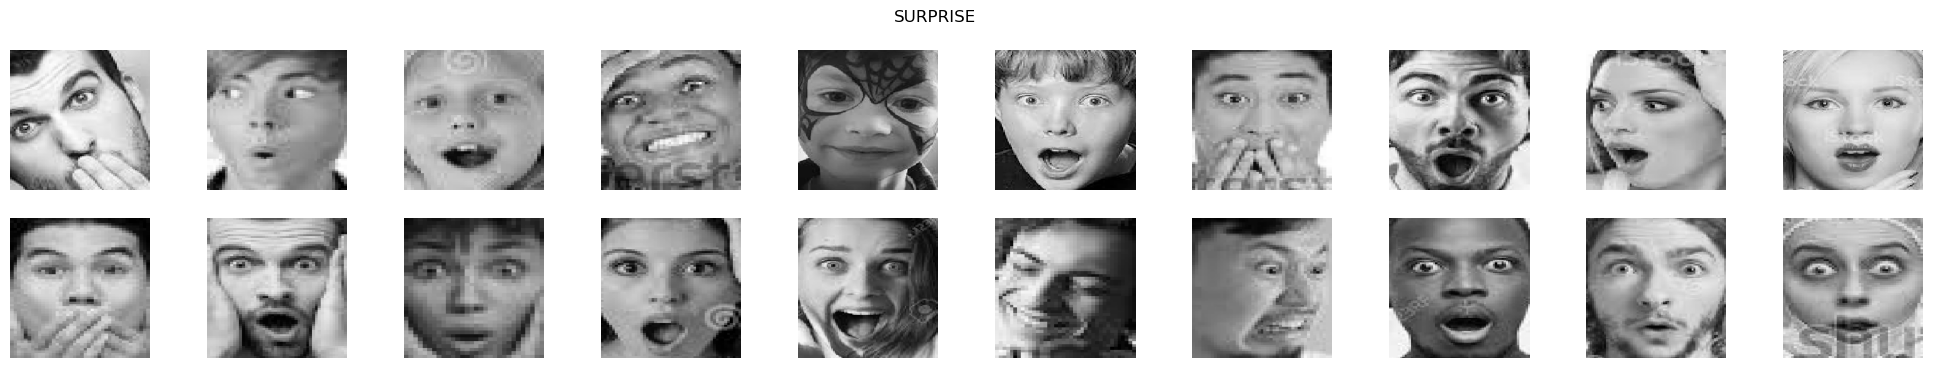

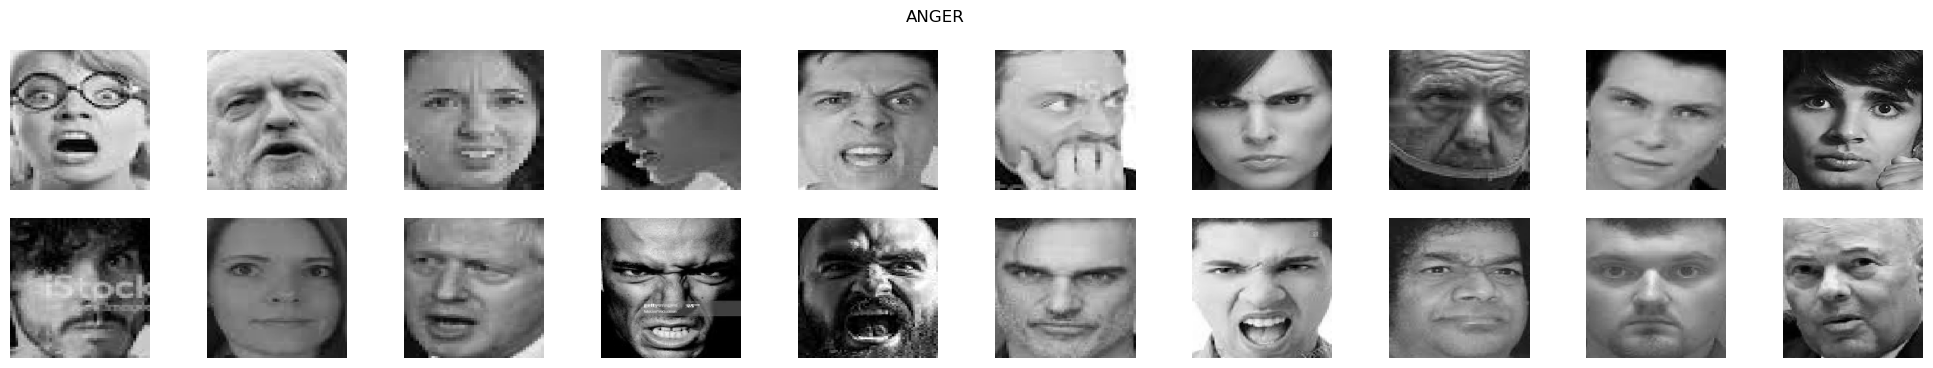

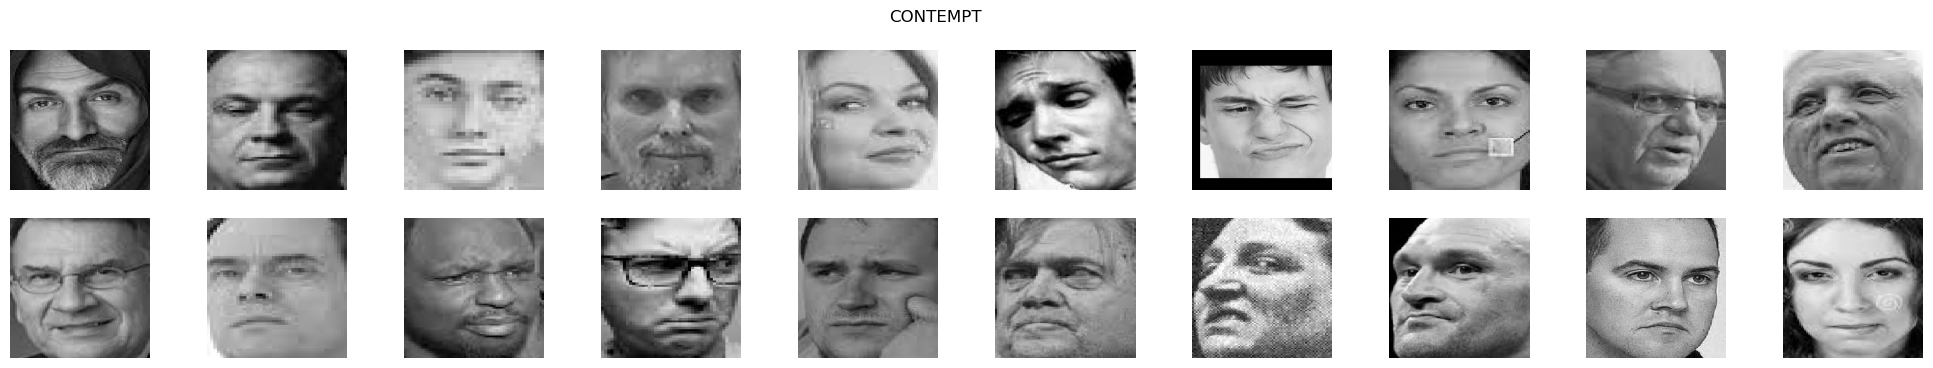

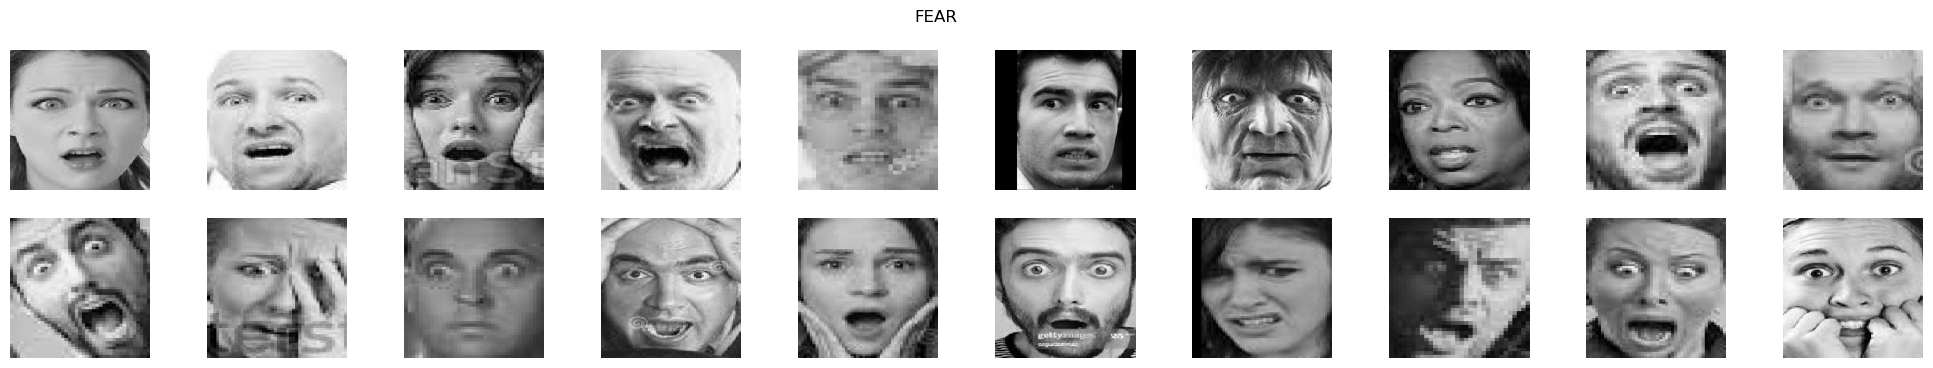

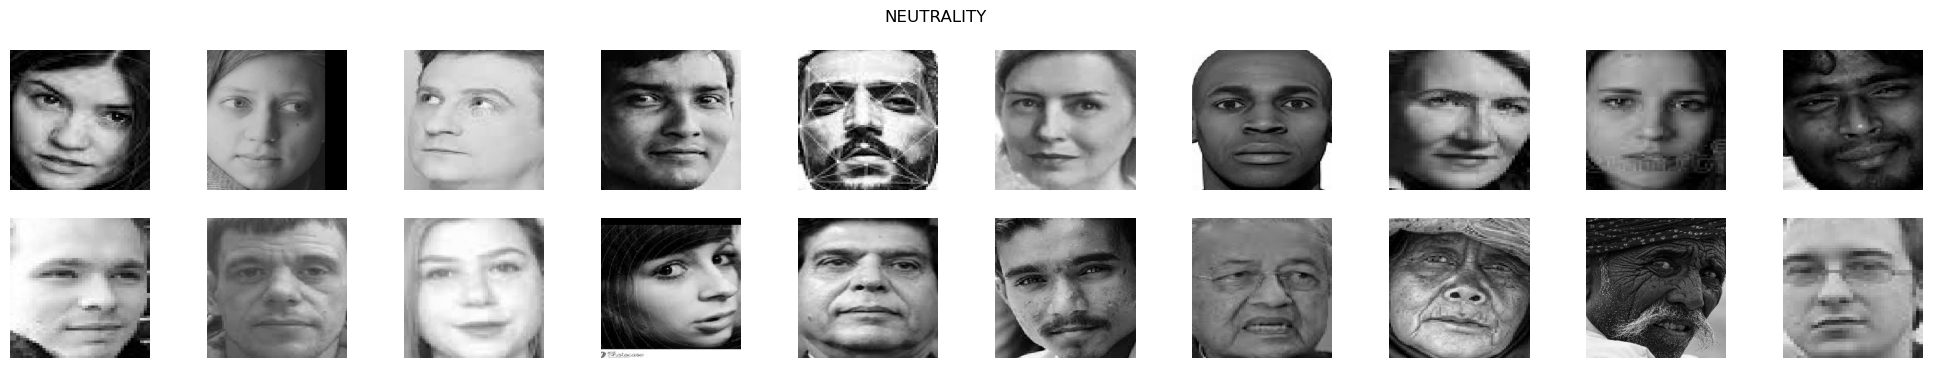

In [5]:
for label in Images:
    images = Images[label]
    class_name = class_names[label]
    f, axs = plt.subplots(2, 10, figsize=(25, 4))
    axs = axs.reshape(-1)
    f.suptitle(class_name.upper())
    for i, image in enumerate(images):
        ax = plt.subplot(2, 10, i + 1)
        axs[i].imshow(image.numpy().astype("uint8"), cmap='gray')
        axs[i].axis("off")    

In [6]:
validation_dataset_cardinality = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_dataset_cardinality // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 69
Number of test batches: 13


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation
data_augmentation = tf.keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05)
        , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1)
    ]
)

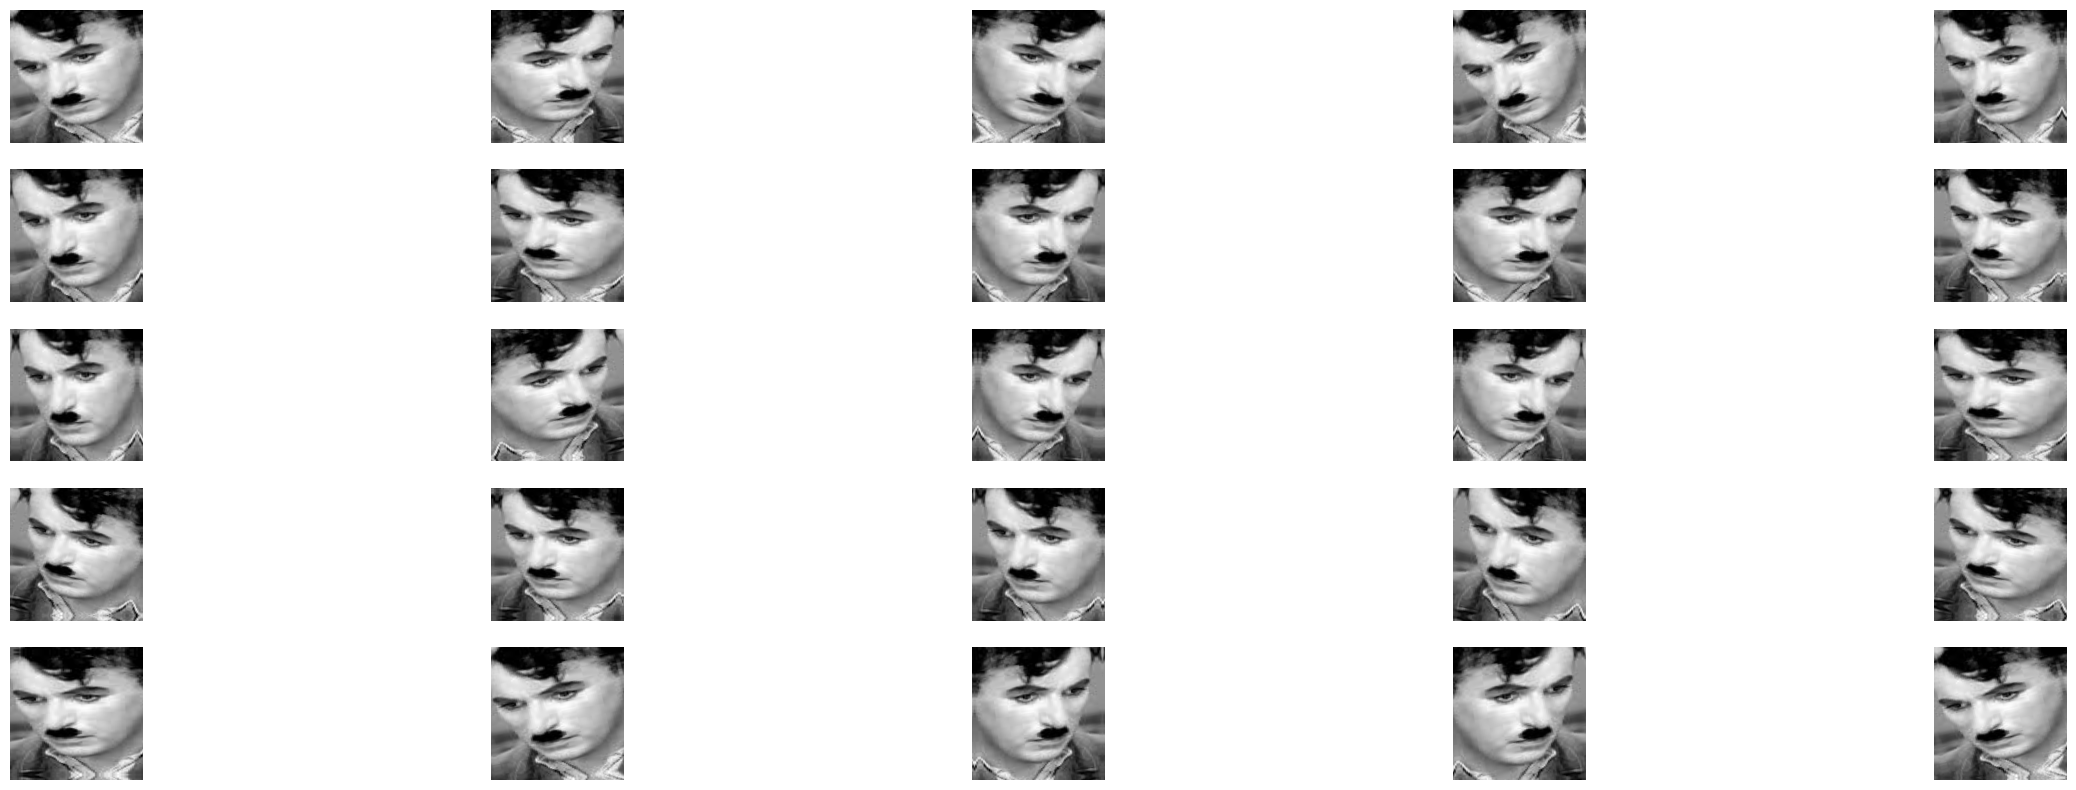

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(30, 10))
    image = images[0]    
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0].numpy() / 255, cmap='gray')
        plt.axis('off')
plt.show()

In [10]:
INPUT_SHAPE = image.shape
# Carregamento do modelo pré-treinado SEM as camadas densas
# (include_top = False)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
# Congela camadas pré-treinadas
for layer in base_model.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
base_model = tf.keras.Sequential([
base_model,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(8, activation='softmax')
])

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 23,604,104
Trainable params: 16,392
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
inputs = layers.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
outputs = base_model(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 8)                 23604104  
                                                                 
Total params: 23,604,104
Trainable params: 16,392
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

2022-11-11 10:25:39.558963: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-11-11 10:25:41.376263: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


(8, 8)


2022-11-11 10:25:42.962357: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [14]:
print('CNN output format')
print(' '.join('{:^12s}'.format(el) for el in class_names))
for row in feature_batch.numpy():
   print(' '.join('{:^12.2f}'.format(el) for el in row))

CNN output format
   anger       contempt     disgust        fear      happiness    neutrality    sadness      surprise  
    0.19         0.58         0.00         0.00         0.04         0.02         0.01         0.15    
    0.15         0.44         0.01         0.01         0.01         0.03         0.25         0.09    
    0.03         0.18         0.01         0.02         0.61         0.05         0.02         0.09    
    0.24         0.17         0.02         0.02         0.07         0.04         0.05         0.38    
    0.19         0.30         0.02         0.05         0.05         0.11         0.15         0.14    
    0.24         0.42         0.00         0.01         0.05         0.03         0.04         0.21    
    0.08         0.55         0.00         0.01         0.05         0.06         0.04         0.21    
    0.05         0.83         0.00         0.00         0.00         0.00         0.02         0.08    


In [15]:
print('Dataset label format')
label_batch.numpy()

Dataset label format


array([1, 6, 4, 3, 5, 0, 6, 1], dtype=int32)

In [16]:
METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

In [18]:
# Compile the model
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [19]:
# Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-11-11 10:26:16.810335: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 594.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


68/69 [============================>.] - ETA: 0s - loss: 2.9058 - accuracy: 0.0956

2022-11-11 10:26:28.304369: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 577.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-11 10:26:29.092841: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


69/69 [==============================] - 14s 177ms/step - loss: 2.9112 - accuracy: 0.0967
initial loss: 2.91
initial accuracy: 0.10


In [20]:
initial_epochs = 100
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
616/617 [============================>.] - ETA: 0s - loss: 2.2669 - accuracy: 0.1735

2022-11-11 10:28:38.954574: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 581.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-11 10:28:39.841264: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


617/617 [==============================] - 131s 208ms/step - loss: 2.2673 - accuracy: 0.1733 - val_loss: 2.2483 - val_accuracy: 0.2153
Epoch 2/100
617/617 [==============================] - 133s 215ms/step - loss: 2.0829 - accuracy: 0.2082 - val_loss: 2.1270 - val_accuracy: 0.2354
Epoch 3/100
617/617 [==============================] - 134s 217ms/step - loss: 2.0148 - accuracy: 0.2349 - val_loss: 2.0578 - val_accuracy: 0.2609
Epoch 4/100
617/617 [==============================] - 134s 217ms/step - loss: 1.9673 - accuracy: 0.2518 - val_loss: 2.0012 - val_accuracy: 0.2737
Epoch 5/100
617/617 [==============================] - 127s 206ms/step - loss: 1.9185 - accuracy: 0.2729 - val_loss: 1.9575 - val_accuracy: 0.2883
Epoch 6/100
617/617 [==============================] - 131s 213ms/step - loss: 1.8941 - accuracy: 0.2877 - val_loss: 1.9208 - val_accuracy: 0.3047
Epoch 7/100
617/617 [==============================] - 129s 209ms/step - loss: 1.8679 - accuracy: 0.3045 - val_loss: 1.8853 - val_

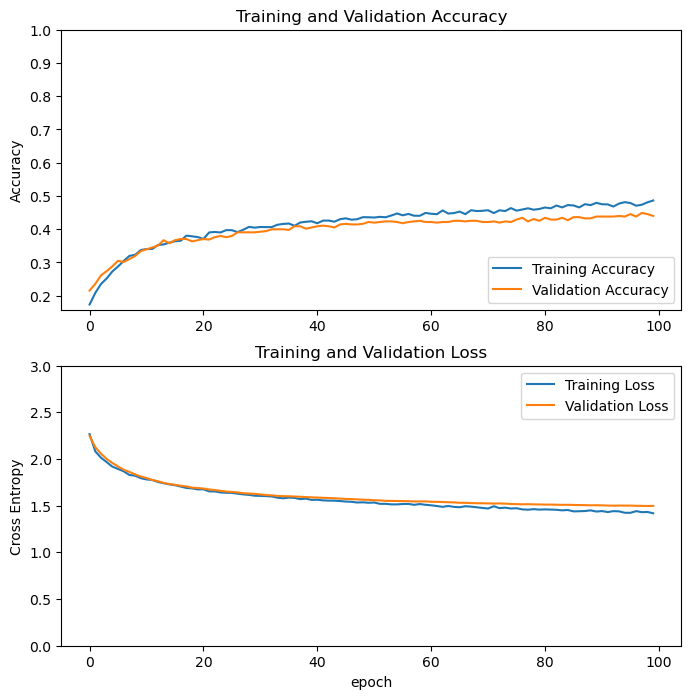

In [21]:
# Show the learning curves of the training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
Labels = []
Predss = []
count = 0
for batch, labels in validation_dataset:
    logits = model.predict_on_batch(batch)
    preds  = np.argmax(logits, axis=1) 
    Predss += preds.tolist()
    Labels += labels.numpy().tolist()
    count  += 1

In [23]:
print('Confusion matrix')
confusion = confusion_matrix(Labels, Predss)
print(' '.join('{:<12s}'.format(el) for el in class_names))
for row in confusion:
    print(' '.join('{:<12d}'.format(el) for el in row))
print('===')
print('Precision per class')
num = [confusion[i,i] for i in range(len(confusion))]
den = np.sum(confusion, axis=0)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean precision: {:<12.2f}'.format(np.mean(num/den)))
print('===')
print('Recall per class')
num = [confusion[i,i] for i in range(len(confusion))]
den = np.sum(confusion, axis=1)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean recall (balanced accuracy score): {:<12.2f}'.format(np.mean(num/den)))

Confusion matrix
anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
41           0            2            3            32           1            2            1           
6            1            1            0            2            1            2            1           
14           0            1            2            21           3            4            4           
7            0            1            13           3            3            3            22          
12           0            1            7            116          2            2            8           
11           1            0            0            17           14           9            1           
21           0            3            3            23           11           13           5           
8            0            0            4            15           1            1            42          
===
Precision per class
anger        contempt  

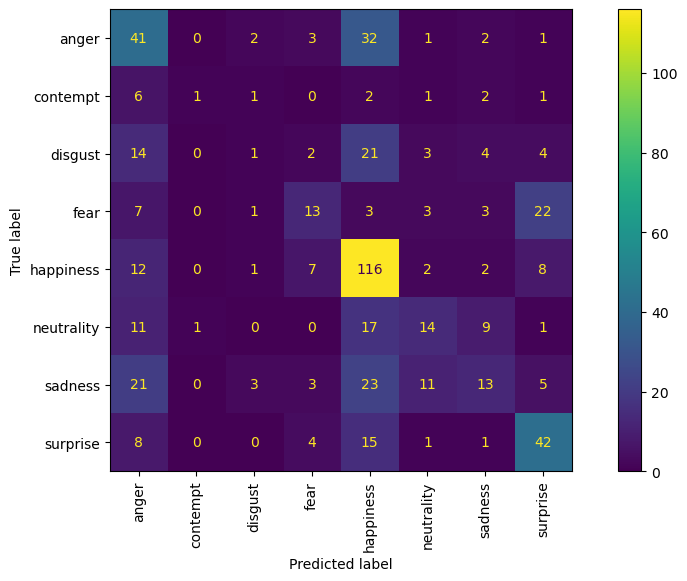

In [24]:
fig, ax = plt.subplots(figsize=(20*0.6, 10*0.6))
ConfusionMatrixDisplay.from_predictions(Labels, Predss, normalize=None, display_labels=class_names, xticks_rotation='vertical', values_format='d', ax=ax)

13/13 [==============================] - 2s 158ms/step - loss: 1.3856 - accuracy: 0.5000
Test accuracy : 0.5
pred [[0.04539801 0.01500451 0.02908461 0.0366473  0.58919483 0.10439281
  0.02320687 0.1570711 ]
 [0.01245848 0.01349305 0.01194952 0.22398044 0.0081681  0.00575061
  0.0258619  0.69833785]
 [0.07380273 0.03605678 0.03028422 0.11693361 0.42546287 0.11744978
  0.01947878 0.18053119]
 [0.17978258 0.02181338 0.10071234 0.10278989 0.31687385 0.01669079
  0.07377824 0.18755892]
 [0.22436188 0.08050489 0.05523223 0.02752505 0.07677433 0.32555306
  0.19758946 0.01245909]
 [0.21005481 0.01375809 0.04403296 0.08803804 0.19666989 0.16237308
  0.1823177  0.10275538]
 [0.17741248 0.01138918 0.07286029 0.06133782 0.5293432  0.01118367
  0.042774   0.09369936]
 [0.34061137 0.08856901 0.09526883 0.01114808 0.08256426 0.11409001
  0.24459812 0.02315032]]
Predictions:
 [4 7 4 4 5 0 4 0]
Labels:
 [4 7 7 0 5 4 6 0]
Classes:
 ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sad

IndexError: index 8 is out of bounds for axis 0 with size 8

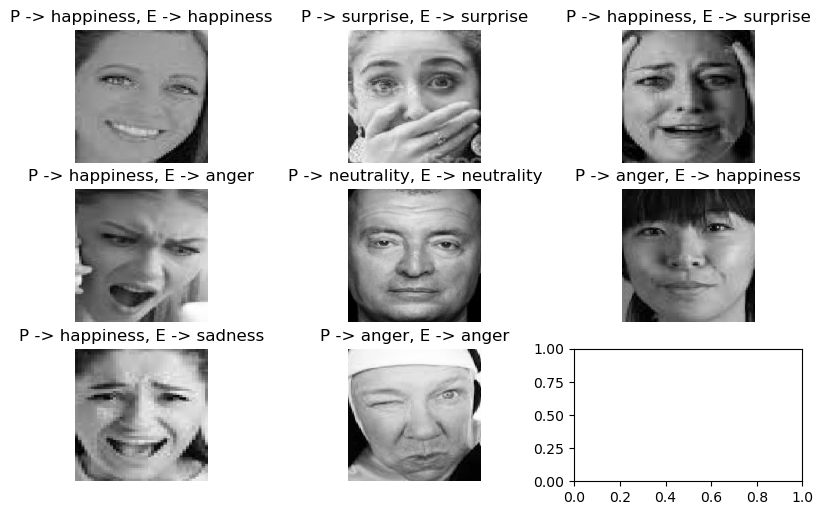

In [25]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print('pred', predictions)


# Apply a sigmoid since our model returns logits
predicted_class = np.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class)
print('Labels:\n', label_batch)
print('Classes:\n', class_names)
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"), cmap='gray')
    plt.title('P -> {}, E -> {}'.format(class_names[predicted_class[i]], class_names[label_batch[i]]))
    plt.axis("off")